In [1]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np 
import matplotlib.pyplot as plt

<img src="../images/1d_heat_eq.png" width="35%">

In [2]:
k = 0.4
L = 1
n = 1

## Set geometry, BC and IC

**IC**

u(x, t = 0) = sin(n*pi*x/L)

**BC**

u(x = 0, t) = 0, 

u(x = 1, t) = 2

In [3]:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, n)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [4]:
ic = dde.icbc.IC(geomtime, lambda x: np.sin(n * np.pi * x[:, 0:1] / L), lambda _, on_initial: on_initial)


In [5]:
# demonstration of working lambda function
input_array = np.array([[1, 2, 3], 
                        [4, 5, 6],
                        [7, 8, 9]])

lambda_function = lambda x: 2 * x[:, 0:1]
result_array = lambda_function(input_array)
result_array

array([[ 2],
       [ 8],
       [14]])

In [6]:
# conditional lambda functions
cond_lambda = lambda x : "Even" if x % 2 == 0 else "Odd"
print(cond_lambda(4))
print(cond_lambda(3))

Even
Odd


In [7]:
def double_first_column(input_array):
    print("input_array", input_array)
    print('input_array.shape=', input_array.shape)
    print("input_array[:, 0:1]", input_array[:, 0:1])  # 0:1 take whole tensor (80, 1)
    print('input_array[:, 0:1].shape=', input_array[:, 0:1].shape)
    print("input_array[:, 0]", input_array[:, 0])
    print('input_array[:, 0].shape=', input_array[:, 0].shape)  # shape will be just vector (80, )
    return 2 * input_array[:, 0:1]

bc = dde.icbc.DirichletBC(
    geomtime,
    lambda input_array: double_first_column(input_array),
    lambda _, 
    on_boundary: on_boundary)

## Define the network and the PDE

In [8]:
def pde(comp, u):
    du_t = dde.grad.jacobian(u, comp, i=0, j=1)
    du_xx = dde.grad.hessian(u, comp, i=0, j=0)
    return du_t - k * du_xx

In [13]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain = 2540,
    num_boundary = 80,
    num_initial = 160,
    num_test = 2540
)

In [14]:
net = dde.nn.FNN([2] + [20]*3 + [1], "tanh", "Glorot normal")

<function matplotlib.pyplot.show(close=None, block=None)>

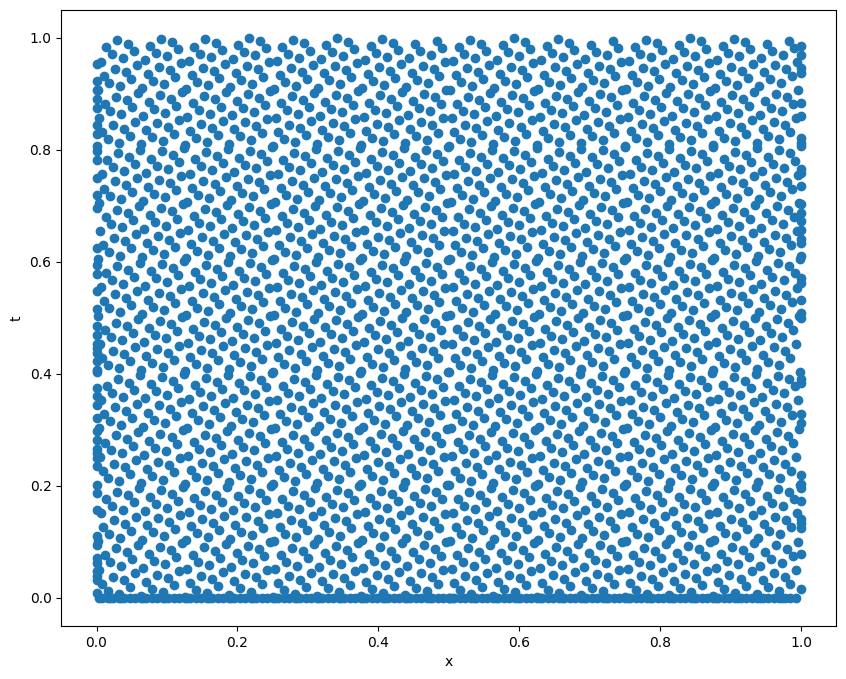

In [26]:
plt.figure(figsize=(10, 8))
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1])
plt.xlabel('x')
plt.ylabel('t')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

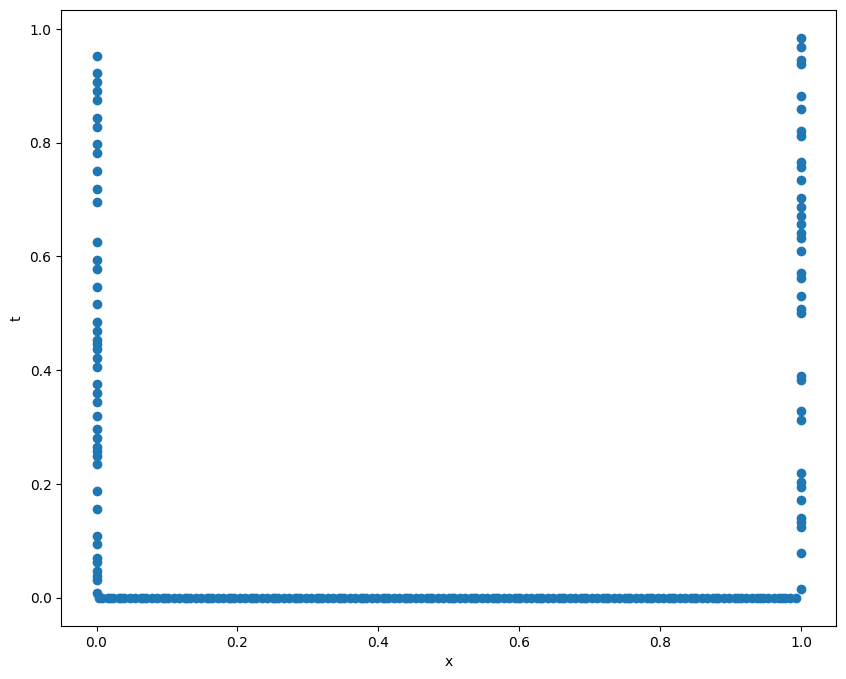

In [27]:
plt.figure(figsize=(10, 8))
plt.scatter(data.train_x_bc[:, 0], data.train_x_bc[:, 1])
plt.xlabel('x')
plt.ylabel('t')
plt.show

In [20]:
data.train_x.shape 

(3020, 2)

In [24]:
data.train_x_all.shape, data.train_x_bc.shape

((2780, 2), (240, 2))

## Train the model

In [28]:
model = dde.Model(data, net)

In [29]:
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.042491 s

input_array [[1.        0.203125 ]
 [0.        0.34375  ]
 [1.        0.140625 ]
 [0.        0.578125 ]
 [0.        0.890625 ]
 [1.        0.3828125]
 [0.        0.0703125]
 [1.        0.8125   ]
 [0.        0.59375  ]
 [1.        0.21875  ]
 [1.        0.6328125]
 [0.        0.0390625]
 [1.        0.7578125]
 [1.        0.5      ]
 [0.        0.515625 ]
 [0.        0.375    ]
 [1.        0.3125   ]
 [1.        0.609375 ]
 [0.        0.71875  ]
 [1.        0.9375   ]
 [0.        0.546875 ]
 [0.        0.296875 ]
 [1.        0.765625 ]
 [0.        0.453125 ]
 [0.        0.75     ]
 [1.        0.703125 ]
 [1.        0.125    ]
 [0.        0.2578125]
 [1.        0.65625  ]
 [0.        0.28125  ]
 [0.        0.46875  ]
 [1.        0.53125  ]
 [0.        0.40625  ]
 [0.        0.796875 ]
 [1.        0.5625   ]
 [0.        0.03125  ]
 [1.        0.734375 ]
 [0.        0.84375  ]
 [0.        0.0625   ]
 [1.   

c:\Users\Yerzhan\python_projects\env\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.228875 s



In [30]:
loss_history, train_state = model.train(iterations=15000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.01e-02, 1.53e+00, 4.28e-01]    [2.15e-02, 1.53e+00, 4.28e-01]    []  
1000      [1.20e-02, 5.74e-02, 1.19e-01]    [8.16e-03, 5.74e-02, 1.19e-01]    []  
2000      [6.16e-03, 3.73e-02, 2.64e-02]    [3.38e-03, 3.73e-02, 2.64e-02]    []  
3000      [3.45e-03, 2.86e-02, 1.57e-02]    [1.75e-03, 2.86e-02, 1.57e-02]    []  
4000      [2.87e-03, 2.52e-02, 1.26e-02]    [1.50e-03, 2.52e-02, 1.26e-02]    []  
5000      [2.36e-03, 2.29e-02, 1.07e-02]    [1.17e-03, 2.29e-02, 1.07e-02]    []  
6000      [2.34e-03, 2.09e-02, 9.79e-03]    [1.25e-03, 2.09e-02, 9.79e-03]    []  
7000      [2.28e-03, 1.96e-02, 9.10e-03]    [1.27e-03, 1.96e-02, 9.10e-03]    []  
8000      [2.12e-03, 1.86e-02, 8.65e-03]    [1.19e-03, 1.86e-02, 8.65e-03]    []  
9000      [1.89e-03, 1.78e-02, 8.28e-03]    [1.05e-03, 1.78e-02, 8.28e-03]    []  
10000     [1.73e-03, 1.71e-02, 7.99e-03]    [9.58e-04, 1.71e-

In [31]:
# Limited-memory Broyden-Fletcher-Goldfarb-Shanno
model.compile("L-BFGS-B")
loss_history, train_state = model.train()

Compiling model...
input_array [[1.        0.203125 ]
 [0.        0.34375  ]
 [1.        0.140625 ]
 [0.        0.578125 ]
 [0.        0.890625 ]
 [1.        0.3828125]
 [0.        0.0703125]
 [1.        0.8125   ]
 [0.        0.59375  ]
 [1.        0.21875  ]
 [1.        0.6328125]
 [0.        0.0390625]
 [1.        0.7578125]
 [1.        0.5      ]
 [0.        0.515625 ]
 [0.        0.375    ]
 [1.        0.3125   ]
 [1.        0.609375 ]
 [0.        0.71875  ]
 [1.        0.9375   ]
 [0.        0.546875 ]
 [0.        0.296875 ]
 [1.        0.765625 ]
 [0.        0.453125 ]
 [0.        0.75     ]
 [1.        0.703125 ]
 [1.        0.125    ]
 [0.        0.2578125]
 [1.        0.65625  ]
 [0.        0.28125  ]
 [0.        0.46875  ]
 [1.        0.53125  ]
 [0.        0.40625  ]
 [0.        0.796875 ]
 [1.        0.5625   ]
 [0.        0.03125  ]
 [1.        0.734375 ]
 [0.        0.84375  ]
 [0.        0.0625   ]
 [1.        0.015625 ]
 [1.        0.96875  ]
 [1.        0.671875 ]
 [0

## Results evaluation

Saving loss history to c:\Users\Yerzhan\python_projects\PINN_courses\Physics Informed Neural Network (PINNs)\PINN_deepxde_1D_heat_Equation\loss.dat ...
Saving training data to c:\Users\Yerzhan\python_projects\PINN_courses\Physics Informed Neural Network (PINNs)\PINN_deepxde_1D_heat_Equation\train.dat ...
Saving test data to c:\Users\Yerzhan\python_projects\PINN_courses\Physics Informed Neural Network (PINNs)\PINN_deepxde_1D_heat_Equation\test.dat ...


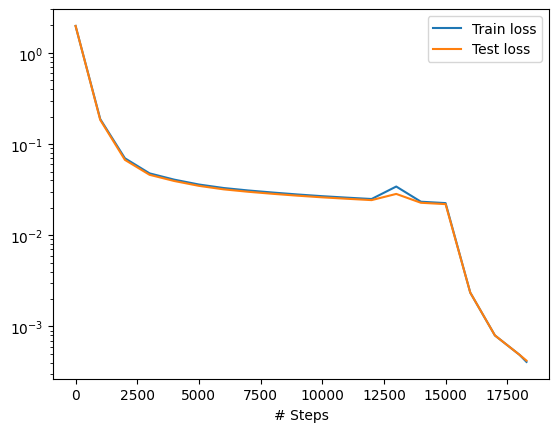

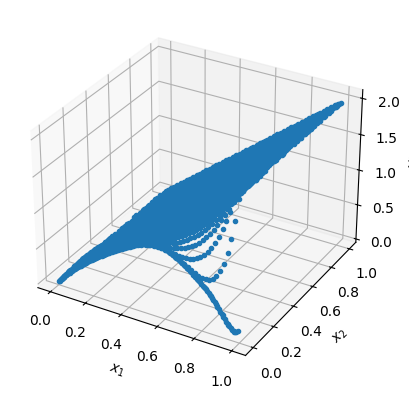

In [32]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)